# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt


Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [82]:
# < ENTER YOUR CODE HERE >
data = pd.read_csv('/content/adult_data_train.csv', na_values=['?']) #в изначальном датасете у нас есть пропущенные значения, отображающиеся как "?". Заменим на наны
data.head(10)



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,HS-grad,9,Never-married,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,7298,0,50,United-States,1
6,44,Private,310255,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,1
7,53,Private,121441,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,55,United-States,0
8,44,Self-emp-inc,191712,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,55,United-States,1
9,28,NaN,149646,Some-college,10,Divorced,NaN,Own-child,White,Female,0,0,20,NaN,0


In [83]:
data.drop(['education', 'marital-status'], axis=1, inplace=True) #удалим лишние столбцы
data.head(10)

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,9,Tech-support,Husband,White,Male,7298,0,50,United-States,1
6,44,Private,310255,10,Craft-repair,Husband,White,Male,0,0,60,United-States,1
7,53,Private,121441,10,Sales,Husband,White,Male,0,0,55,United-States,0
8,44,Self-emp-inc,191712,14,Prof-specialty,Husband,White,Male,0,2415,55,United-States,1
9,28,NaN,149646,10,NaN,Own-child,White,Female,0,0,20,NaN,0


Определите количество числовых и нечисловых признаков.

In [ ]:
# < ENTER YOUR CODE HERE >

In [71]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

print('Числовые', numerical_features, "Категориальные", categorical_features)
#Видим, что числовых - 7, категориальных - 6

Числовые Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'label'],
      dtype='object') Категориальные Index(['workclass', 'occupation', 'relationship', 'race', 'sex',
       'native-country'],
      dtype='object')


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

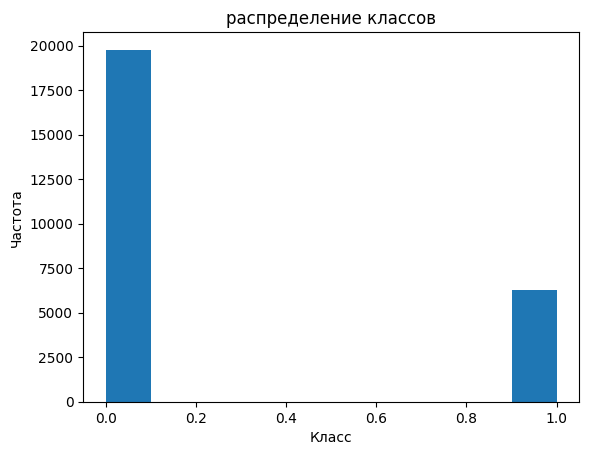

Доля объектов класса 0: 0.759


In [ ]:
# < ENTER YOUR CODE HERE >
# Построение гистограммы распределения объектов по классам
plt.hist(data['label'])
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.title('распределение классов')
plt.show()

# Вычисление доли объектов класса 0
class_0_fraction = (data['label'].value_counts()[0] / len(data))
class_0_fraction = class_0_fraction.round(3)
print("Доля объектов класса 0:", class_0_fraction)

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [ ]:
# < ENTER YOUR CODE HERE >
#отберем только числовые признаки
data.drop(['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country'], axis=1, inplace=True)
data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
0,32,37210,13,0,0,45,1
1,43,101950,14,0,0,45,0
2,20,122244,9,0,0,28,0
3,40,24763,10,6849,0,40,0
4,24,113936,13,0,0,40,0
...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0
26044,39,421633,10,0,0,30,0
26045,55,82098,9,0,0,55,0
26046,26,50053,13,0,0,55,0


In [ ]:
X = data.drop(['label'], axis=1) #предикторы
y = data['label']                #отклики
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)



In [ ]:
# Вычисление выборочного среднего колонки fnlwgt тренировочного набора данных
fnlwgt_mean = X_train['fnlwgt'].mean()
fnlwgt_mean.round(3)


190199.121

In [ ]:
# Обучение модели KNeighborsClassifier с параметрами по умолчанию
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)



KNeighborsClassifier()

In [ ]:
# Оценка модели на тестовых данных
y_pred = knn_classifier.predict(X_test)

# Вычисление f1_score для тестового набора данных
f1 = f1_score(y_test, y_pred).round(3)
f1

0.379

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [ ]:
# < ENTER YOUR CODE HERE >
scaler = MinMaxScaler()

# Преобразование тренировочных и тестовых данных с использованием MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Вычисление выборочного среднего колонки fnlwgt тренировочного набора данных после нормировки
fnlwgt_mean_scaled = X_train_scaled[:, data.columns.get_loc('fnlwgt')].mean()
fnlwgt_mean_scaled.round(3)

0.121

In [ ]:
# datacolumns.get_loc('fnlwgt'): Эта часть кода использует метод get_loc() для получения индекса столбца 'fnlwgt' в датафрейме data.
#Метод get_loc() возвращает индекс (позицию) столбца по его имени.

#X_train_scaled[:, numeric_features.columns.get_loc('fnlwgt')] После того, как мы получили индекс столбца 'fnlwgt', мы используем его для извлечения всех строк (':') и только столбца с индексом 'fnlwgt' из массива X_train_scaled.
#Проще говоря, мы выбираем все значения в столбце 'fnlwgt' из массива X_train_scaled.

In [ ]:
# Обучение модели на преобразованных данных
knn_classifier_scaled = KNeighborsClassifier()
knn_classifier_scaled.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [ ]:
# Оценка модели на преобразованных тестовых данных
y_pred_scaled = knn_classifier_scaled.predict(X_test_scaled)

# Вычисление f1_score для преобразованных тестовых данных
f1_scaled = f1_score(y_test, y_pred_scaled).round(3)
f1_scaled

0.505

Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [ ]:
# < ENTER YOUR CODE HERE >
# Построение гистограмм для каждого нечислового признака
for feature in categorical_features:

    sns.countplot(data=data, x=feature)
    plt.title("Гистограмма частоты значений для признака '{}'".format(feature))
    plt.xticks(rotation=45)
    plt.show()


ValueError: Could not interpret value `workclass` for `x`. An entry with this name does not appear in `data`.

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [60]:
# < ENTER YOUR CODE HERE >
# Подсчет числа строк с пропущенными значениями
num_missing_values = data.isnull().any(axis=1).sum()

print("Число строк с хотя бы одним пропущенным значением:", num_missing_values)

Число строк с хотя бы одним пропущенным значением: 1914


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [61]:
# < ENTER YOUR CODE HERE >
# Удаление строк с пропущенными значениями
data_cleaned = data.dropna()

# One-hot кодирование нечисловых признаков
data_encoded = pd.get_dummies(data_cleaned, drop_first=True)

# Вывод числа полученных признаков
num_features = data_encoded.shape[1]
print("Число полученных признаков:", num_features - 1)

Число полученных признаков: 75


In [62]:
data_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,51,237630,9,7298,0,50,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,179171,9,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26044,39,421633,10,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26045,55,82098,9,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
26046,26,50053,13,0,0,55,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [64]:
# < ENTER YOUR CODE HERE >
# Определение признаков и целевой переменной
X = data_encoded.drop('label', axis=1)
y = data_encoded['label']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)



In [65]:
scaler = MinMaxScaler()

# Преобразование тренировочных и тестовых данных с использованием MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# Инициализация и обучение модели кнн
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [67]:
# Предсказание на тестовом наборе
y_pred = model.predict(X_test_scaled)

# Вычисление f1 модели
f1 = f1_score(y_test, y_pred)

print("F1-скор модели:", f1.round(3))

F1-скор модели: 0.6


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [84]:
data

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [85]:
# < ENTER YOUR CODE HERE >
# Заполнение пропущенных значений самым часто встречающимся значением в каждом столбце
data = data.fillna(data.mode().iloc[0])
data.head(10)

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,Private,122244,9,Prof-specialty,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
5,51,Private,237630,9,Tech-support,Husband,White,Male,7298,0,50,United-States,1
6,44,Private,310255,10,Craft-repair,Husband,White,Male,0,0,60,United-States,1
7,53,Private,121441,10,Sales,Husband,White,Male,0,0,55,United-States,0
8,44,Self-emp-inc,191712,14,Prof-specialty,Husband,White,Male,0,2415,55,United-States,1
9,28,Private,149646,10,Prof-specialty,Own-child,White,Female,0,0,20,United-States,0


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [86]:
# < ENTER YOUR CODE HERE >
# One-hot кодирование нечисловых признаков
data_encoded = pd.get_dummies(data, drop_first=True)

In [88]:
# Определение признаков и целевой переменной
X = data_encoded.drop('label', axis=1)
y = data_encoded['label']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

In [89]:
scaler = MinMaxScaler()

# Преобразование тренировочных и тестовых данных с использованием MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
# Инициализация и обучение модели логистической регрессии
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [91]:
# Предсказание на тестовом наборе
y_pred = model.predict(X_test_scaled)

# Вычисление f1 модели
f1 = f1_score(y_test, y_pred)

print("F1-скор модели:", f1.round(3))

F1-скор модели: 0.61


## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.